In [2]:
from model import CNN
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
CHANNELS_D = 3

img_size = 400
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "model.pth"
data_dir = "~/Documents/datasets/archive/caltech101_classification/"

classes = ["Motorcycle", "Airplane", "Schooner"]

In [3]:
def norm_transforms(dir):
    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ]
    )
    dataset = datasets.ImageFolder(root=dir, transform=transform)
    # concat image data (CxWxH) in tensor, discard labels
    imgs = torch.stack([img_t for img_t, _ in dataset], dim=3)
    # flatten the three channels of all images and take the mean
    mean = np.array([m for m in imgs.view(3, -1).mean(dim=1)])
    std = np.array([s for s in imgs.view(3, -1).std(dim=1)])

    norm = transforms.Normalize(
        mean = mean,
        std = std
    )
    unorm = transforms.Normalize(
        mean = -(mean/std),
        std = (1 / std)
    )
    
    return norm, unorm

norm, unorm = norm_transforms(data_dir)

In [4]:
def load_data(dir):
    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            norm,
        ]
    )
    dataset = datasets.ImageFolder(
        root=dir,
        transform=transform)

    train_size = int(0.6 * len(dataset))
    test_val_size = len(dataset) - train_size
    train_data, test_val_data = torch.utils.data.random_split(dataset, [train_size, test_val_size])

    val_size = int(0.5 * len(test_val_data))
    test_size = len(test_val_data) - val_size
    val_data, test_data = torch.utils.data.random_split(test_val_data, [val_size, test_size])
    
    return train_data, val_data, test_data
train_data, val_data, test_data = load_data("~/Documents/datasets/archive/caltech101_classification/")

In [5]:
def gen_layers(num_layers, expansion):
    layers = []
    in_channels = 3
    
    # use batchnorm to prevent over/under shooting
    for i in range(num_layers):
        out_channels = expansion(in_channels)
        # out_channels = expansion * in_channels
        layers += [nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)]
        layers += [nn.ReLU(), nn.BatchNorm2d(out_channels, affine=False)]
        layers += [nn.MaxPool2d(2, 2)]
        in_channels = out_channels

    # num params
    # print(((img_size // (2 ** num_layers)) ** 2) * in_channels)
    fcl = ((img_size // (2 ** num_layers)) ** 2) * in_channels
    layers += [nn.Flatten(1), nn.BatchNorm1d(fcl, affine=False), nn.Linear(fcl, 256)]
    layers += [nn.ReLU(), nn.Linear(256, 3), nn.ReLU()]
    
    return nn.Sequential(*layers)

class CNN(nn.Module):
    def __init__(self, num_layers, expansion):
        super().__init__()
        self.expansion = expansion
        self.num_layers = num_layers
        self.net = nn.Sequential(
            gen_layers(self.num_layers, self.expansion)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
def eval(model, data):
    with torch.no_grad():
        correct = 0

        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)

            pred = model(img_input)
            _, pred = torch.max(pred.squeeze(), 0)
            pred = pred.to("cpu")
            correct += classes[pred.item()] == classes[label]
        return correct, round((correct / len(data) * 100), 3)

In [7]:
def train(model, train_data, batch, epochs, lr):
    CHANNELS_D = 3
    # LEARNING_RATE = 1e-4

    loader = DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=2)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (imgs, labels) in enumerate(tqdm(loader)):
            inputs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        _, train_acc = eval(model, train_data)
        _, val_acc = eval(model, val_data)
        model.train()
        
        print(f'epoch: {epoch + 1} loss: {running_loss / batch:.6f}')
        losses.append((epoch, float(f"{(running_loss / batch):.6f}"), train_acc, val_acc))
        running_loss = 0.0
    
    return losses

def save(model, path):
    torch.save(model.state_dict(), path)

In [8]:
def eval(model, data):
    with torch.no_grad():
        correct = 0

        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)

            pred = model(img_input).to('cpu')
            _, pred = torch.max(pred.squeeze(), 0)
            
            correct += classes[pred.item()] == classes[label]
        return correct, round((correct / len(data) * 100), 3)

In [9]:
def sample(model, test_data):
    with torch.no_grad():
        figure = plt.figure(figsize=(10, 8))
        cols, rows = 4, 4
        correct = 0

        for i in range(1, cols * rows + 1):
            rand = torch.randint(len(test_data), size=(1,)).item()
            img, label = test_data[rand]
            img_input = img.to(device).unsqueeze(0)

            figure.add_subplot(rows, cols, i)
            img = unorm(img)
            npimg = np.transpose(img.numpy(), (1, 2, 0))

            plt.title(f"({i}) {classes[label]}")
            plt.axis("off",)
            plt.imshow((npimg * 255).astype(np.uint8))

            pred = model(img_input).to('cpu')

            _, pred = torch.max(pred.squeeze(), 0)
    
            print(f"({i}) Prediction: {classes[pred.item()]}, Actual: {classes[label]}")
            correct += classes[pred.item()] == classes[label]
        
        print(f"\n {correct} / {cols * rows} correct -> {correct / (cols * rows) * 100} %")
        plt.show()

In [10]:
runs, expansions = [], []
lrs = [1e-4, 2e-3, 35e-4, 0.01]
num_layers = 4
# recursive expressions to use for expanding feature map from conv layer (number of kernels)
expansions.append(lambda x: x + 13)
expansions.append(lambda x: x*2 if x < 20 else x + (x // 2))
expansions.append(lambda x: x*3 if x < 50 else x + (x // 6))


In [ ]:
# use data loader for eval func to use batches
# speed up train time
for n in range(num_layers):
    for expr in expansions:
        model = CNN(n + 1, expr).to(device)
        losses = train(model, train_data, batch=100, epochs=30, lr=lrs[n])
        model.eval() # set eval for batch norm bc batch size is only 1
        _, accuracy = eval(model, val_data)
        runs.append((n, expr, losses, accuracy))

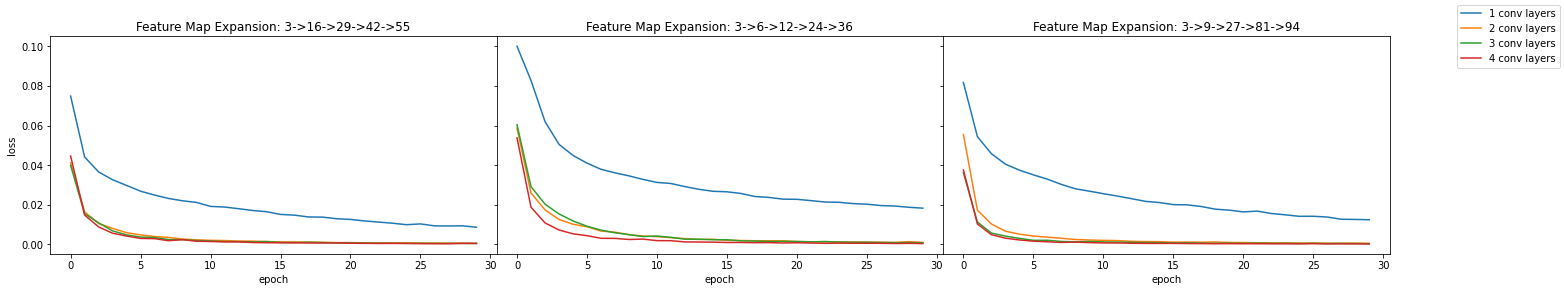

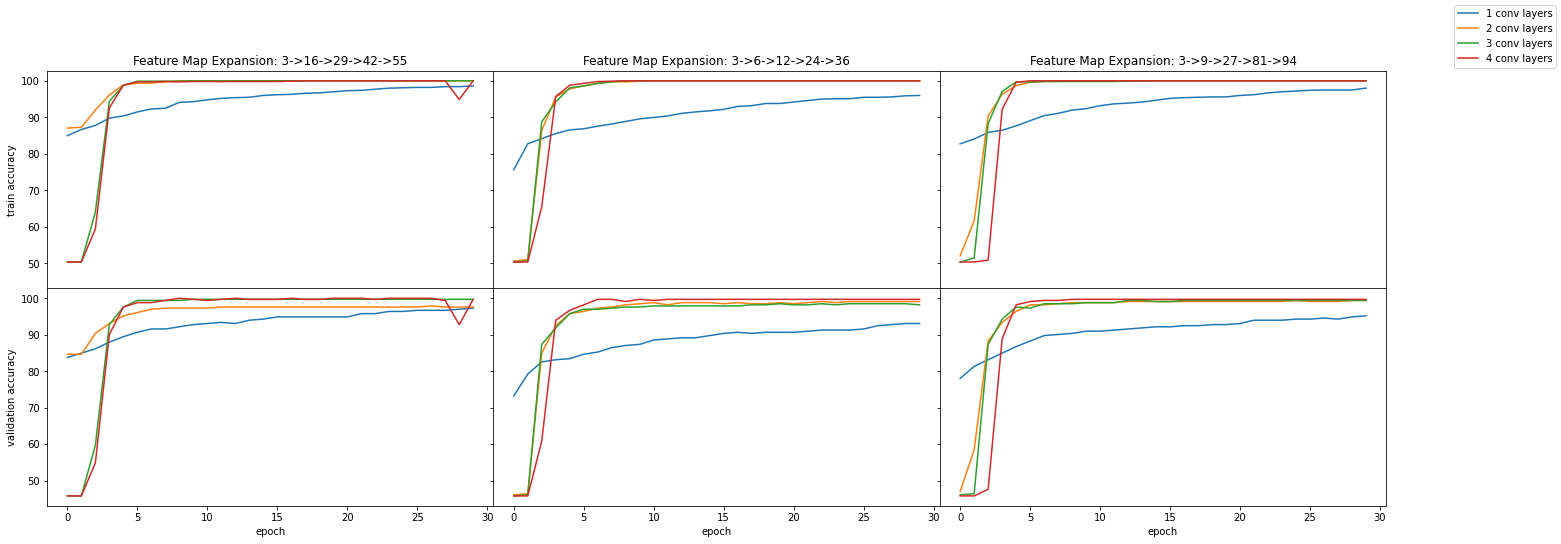

In [72]:
def str_conv_seq(expr, n_lay):
    prior = CHANNELS_D
    conv_seq = str(prior)
    for i in range(n_lay + 1):
        prior = expr(prior)
        conv_seq += f"->{str(prior)}"
    return conv_seq

def plot_losses(runs):
    fig, axs = plt.subplots(1, len(expansions), figsize=(24,4),
        gridspec_kw={'wspace': 0}, sharey=True)

    axs[0].set(ylabel="loss")
    for (n_lay, expr, epoch_loss, accuracy) in runs:
        c = expansions.index(expr)
        conv_seq = str_conv_seq(expr, n_lay)
        train_info = [*zip(*epoch_loss)]
        axs[c].set_title("Feature Map Expansion: " + conv_seq)
        if c == len(expansions) - 1:
            axs[c].plot(train_info[0], train_info[1], label=f"{n_lay + 1} conv layers")    
        else:
            axs[c].plot(train_info[0], train_info[1])
        axs[c].set(xlabel="epoch")
        axs[c].set(xlabel="epoch")

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels)

def plot_accuracies(runs):
    fig, axs = plt.subplots(2, len(expansions), figsize=(24,8),
        gridspec_kw={'hspace': 0, 'wspace': 0}, sharey=True)

    axs[0, 0].set(ylabel='train accuracy')
    axs[1, 0].set(ylabel='validation accuracy')
    for (n_lay, expr, epoch_loss, accuracy) in runs:
        c = expansions.index(expr)
        conv_seq = str_conv_seq(expr, n_lay)
        train_info = [*zip(*epoch_loss)]

        if c == len(expansions) - 1:
            axs[0, c].plot(train_info[0], train_info[2], label=f"{n_lay + 1} conv layers") 
        else:
            axs[0, c].plot(train_info[0], train_info[2])
        
        axs[0, c].set_title("Feature Map Expansion: " + conv_seq)
        axs[1, c].plot(train_info[0], train_info[3])
        axs[0, c].set(xlabel="epoch")
        axs[1, c].set(xlabel="epoch")

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels)

plot_losses(runs)
plot_accuracies(runs)

In [33]:
# model.eval()
# correct, accuracy = eval(model, val_data)
# model.train()
# runs.append((3, expansions[1], losses, accuracy))
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f"number of model parameters: {count_parameters(model)}")
# print(f"{str_conv_seq(expansions[1], 3)} accuracy: {accuracy}, correct: {correct} / {len(val_data)}")

number of model parameters: 5792155
3->6->12->24->36 accuracy: 98.795, correct: 328 / 332
